**To improve recommendations, we need to build a new table**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import json

In [5]:
df_users = pd.read_csv('../data/users_final_with_clusters.csv')
df_contents = pd.read_csv('../raw_data/contents_v3.csv', low_memory=False) 
df_content_topics = pd.read_csv('../data/content_with_topics.csv')

print(f"✅ Users: {len(df_users)} lignes")
print(f"✅ Contents: {len(df_contents)} lignes") 
print(f"✅ Content with topics: {len(df_content_topics)} lignes")
print(f"✅ Clusters disponibles: {sorted(df_users['cluster'].unique())}")

/tmp/ipykernel_13309/4264627908.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_users = pd.read_csv('../data/users_final_with_clusters.csv')


✅ Users: 198895 lignes
✅ Contents: 4898 lignes
✅ Content with topics: 1416 lignes
✅ Clusters disponibles: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [11]:
df_content_topics.head(3)

,id,reduced topics
0,371,0
1,45,-1
2,597,-1


In [12]:
cluster_topics = {
    0: [0, 1, 14],  # Peu Engagés Primaire (en plus du -1)
    1: [0, 1, 2],   # Actifs Polyvalents (en plus du -1)
    2: [0, 1, 2],   # Super Users (en plus du -1)
    3: [0, 1, 14],  # Email-Heavy (en plus du -1)
    4: [0, 1, 14]   # Peu Engagés Secondaire (en plus du -1)
}

# Mapping topic ID -> nom (pour référence)
topic_labels = {
    "-1": "Gestion du décrochage scolaire",
    "0": "Pédagogie en plein air",
    "1": "Activités d'orientation et outils pédagogiques",
    "2": "Travailler l'écoute",
    "3": "Gestion du bruit en classe",
    "4": "Aménagement flexible de la classe",
    "5": "Ressources pour l'orthographe",
    "6": "Accompagnement des Élèves à Besoins Éducatifs Particuliers",
    "7": "Gestion de l'attention et de la mémoire",
    "8": "Remédiation pour les besoins éducatifs particuliers",
    "9": "Gestion du stress",
    "10": "Gestion des émotions",
    "11": "Développement des Compétences Psychosociales",
    "12": "Relations école-famille",
    "13": "Troubles spécifiques du langage écrit et des apprentissages",
    "14": "Les croyances sur l'intelligence",
    "15": "Gestion des sanctions et règles"
}

print("🎯 Topics populaires par cluster:")
for cluster_id, topics in cluster_topics.items():
    topic_names = [topic_labels[str(t)] for t in topics]
    print(f"Cluster {cluster_id}: {topics} -> {topic_names}")

🎯 Topics populaires par cluster:
Cluster 0: [0, 1, 14] -> ['Pédagogie en plein air', "Activités d'orientation et outils pédagogiques", "Les croyances sur l'intelligence"]
Cluster 1: [0, 1, 2] -> ['Pédagogie en plein air', "Activités d'orientation et outils pédagogiques", "Travailler l'écoute"]
Cluster 2: [0, 1, 2] -> ['Pédagogie en plein air', "Activités d'orientation et outils pédagogiques", "Travailler l'écoute"]
Cluster 3: [0, 1, 14] -> ['Pédagogie en plein air', "Activités d'orientation et outils pédagogiques", "Les croyances sur l'intelligence"]
Cluster 4: [0, 1, 14] -> ['Pédagogie en plein air', "Activités d'orientation et outils pédagogiques", "Les croyances sur l'intelligence"]


In [15]:
print("🔗 Jointure contents + topics...")

# Joindre df_contents avec df_content_topics
df_base = df_contents[['id', 'title', 'type']].merge(
    df_content_topics[['id', 'reduced topics']], 
    on='id', 
    how='inner'
)

print(f"✅ Contenus avec topics: {len(df_base)}")
print(f"✅ Topics disponibles: {sorted(df_base['reduced topics'].unique())}")

# Vérifier qu'on a bien les topics qu'on cherche
target_topics = [-1, 0, 1, 2, 14]
available_topics = df_base['reduced topics'].unique()
missing_topics = [t for t in target_topics if t not in available_topics]

if missing_topics:
    print(f"⚠️  Topics manquants: {missing_topics}")
else:
    print(f"✅ Tous les topics cibles sont disponibles")

🔗 Jointure contents + topics...
✅ Contenus avec topics: 2184
✅ Topics disponibles: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]
✅ Tous les topics cibles sont disponibles


In [16]:
print("🎯 Création des assignations cluster...")

# Initialiser toutes les colonnes cluster à False
for cluster_id in range(5):
    df_base[f'cluster_{cluster_id}'] = False

# Pour chaque contenu, vérifier si son topic correspond aux clusters
for idx, row in df_base.iterrows():
    content_topic = row['reduced topics']
    
    # Vérifier chaque cluster
    for cluster_id in range(5):
        cluster_target_topics = cluster_topics[cluster_id] + [-1]  # Ajouter le topic -1 pour tous
        
        if content_topic in cluster_target_topics:
            df_base.loc[idx, f'cluster_{cluster_id}'] = True

print("✅ Assignations terminées!")

🎯 Création des assignations cluster...
✅ Assignations terminées!


In [18]:
# Vérification de la distribution
print("\n📊 Distribution des contenus par cluster:")
for cluster_id in range(5):
    count = df_base[f'cluster_{cluster_id}'].sum()
    pct = (count / len(df_base)) * 100
    print(f"Cluster {cluster_id}: {count} contenus ({pct:.1f}%)")

# Vérification par topic
print("\n📊 Distribution par topic:")
for topic in [-1, 0, 1, 2, 14]:
    count = (df_base['reduced topics'] == topic).sum()
    if count > 0:
        topic_name = topic_labels[str(topic)]
        print(f"Topic {topic} ({topic_name}): {count} contenus")


📊 Distribution des contenus par cluster:
Cluster 0: 1528 contenus (70.0%)
Cluster 1: 1622 contenus (74.3%)
Cluster 2: 1622 contenus (74.3%)
Cluster 3: 1528 contenus (70.0%)
Cluster 4: 1528 contenus (70.0%)

📊 Distribution par topic:
Topic -1 (Gestion du décrochage scolaire): 855 contenus
Topic 0 (Pédagogie en plein air): 427 contenus
Topic 1 (Activités d'orientation et outils pédagogiques): 232 contenus
Topic 2 (Travailler l'écoute): 108 contenus
Topic 14 (Les croyances sur l'intelligence): 14 contenus


In [19]:
print("🎯 Ajout des priority challenges...")

# Colonnes de défis prioritaires dans df_contents
priority_columns = ['transition_ecologique', 'sante_mentale', 'ecole_inclusive', 'cps', 'reussite_tous_eleves']
priority_names = {
    'transition_ecologique': 'Transition écologique',
    'sante_mentale': 'Santé mentale', 
    'ecole_inclusive': 'École inclusive',
    'cps': 'Compétences psychosociales',
    'reussite_tous_eleves': 'Réussite de tous les élèves'
}

# Vérifier quelles colonnes existent
available_priority_cols = [col for col in priority_columns if col in df_contents.columns]
print(f"Colonnes priority disponibles: {available_priority_cols}")

# Initialiser la colonne
df_base['priority_challenge'] = None

if available_priority_cols:
    # Pour chaque contenu, vérifier quel défi prioritaire il a
    for idx, row in df_base.iterrows():
        content_id = row['id']
        
        # Trouver la ligne correspondante dans df_contents
        content_row = df_contents[df_contents['id'] == content_id]
        
        if not content_row.empty:
            content_data = content_row.iloc[0]
            
            # Chercher le premier défi prioritaire actif (valeur = 1)
            for col in available_priority_cols:
                if content_data[col] == 1:
                    df_base.loc[idx, 'priority_challenge'] = priority_names[col]
                    break  # Prendre seulement le premier trouvé
    
    # Statistiques
    priority_count = df_base['priority_challenge'].notna().sum()
    print(f"✅ Contenus avec priority challenge: {priority_count}")
    
    # Distribution par type de défi
    priority_dist = df_base['priority_challenge'].value_counts()
    print("Distribution par défi:")
    for challenge, count in priority_dist.items():
        print(f"  - {challenge}: {count}")
        
else:
    print("⚠️  Aucune colonne de défi prioritaire trouvée")



🎯 Ajout des priority challenges...
Colonnes priority disponibles: ['transition_ecologique', 'sante_mentale', 'ecole_inclusive', 'cps', 'reussite_tous_eleves']
✅ Contenus avec priority challenge: 558
Distribution par défi:
  - Réussite de tous les élèves: 230
  - École inclusive: 101
  - Transition écologique: 96
  - Compétences psychosociales: 88
  - Santé mentale: 43


In [25]:
print("\n💾 SAUVEGARDE DU CSV FINAL")
print("=" * 30)

# Colonnes finales dans l'ordre
final_columns = ['id', 'title', 'type', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'priority_challenge']
df_final = df_base[final_columns].copy()

# Statistiques finales
print(f"📊 STATISTIQUES FINALES:")
print(f"Total contenus: {len(df_final)}")
print(f"Contenus par cluster:")
for cluster_id in range(5):
    count = df_final[f'cluster_{cluster_id}'].sum()
    print(f"  - Cluster {cluster_id}: {count} contenus")

priority_count = df_final['priority_challenge'].notna().sum()
print(f"Priority challenges: {priority_count} contenus")

# Vérifier qu'on a assez de contenus par cluster (minimum pour les recommandations)
print(f"\n🎯 Vérification suffisance pour recommandations (5 contenus):")
for cluster_id in range(5):
    cluster_contents = df_final[df_final[f'cluster_{cluster_id}'] == True]
    count = len(cluster_contents)
    status = "✅" if count >= 5 else "⚠️"
    print(f"{status} Cluster {cluster_id}: {count} contenus")

# Sauvegarder
output_path = '../data/content_recommendations_mapping.csv'
df_final.to_csv(output_path, index=False)

print(f"\n🎉 CSV SAUVEGARDÉ: {output_path}")
print(f"📁 Dimensions: {df_final.shape}")
print(f"🗂️  Colonnes: {list(df_final.columns)}")

print(f"\n✅ Prêt pour le recommender simplifié!")
print(f"📝 Structure: 1 topic -1 + 1 de chaque autre topic + 1 priority challenge = 5 recos")


💾 SAUVEGARDE DU CSV FINAL
📊 STATISTIQUES FINALES:
Total contenus: 2184
Contenus par cluster:
  - Cluster 0: 1528 contenus
  - Cluster 1: 1622 contenus
  - Cluster 2: 1622 contenus
  - Cluster 3: 1528 contenus
  - Cluster 4: 1528 contenus
Priority challenges: 558 contenus

🎯 Vérification suffisance pour recommandations (5 contenus):
✅ Cluster 0: 1528 contenus
✅ Cluster 1: 1622 contenus
✅ Cluster 2: 1622 contenus
✅ Cluster 3: 1528 contenus
✅ Cluster 4: 1528 contenus

🎉 CSV SAUVEGARDÉ: ../data/content_recommendations_mapping.csv
📁 Dimensions: (2184, 9)
🗂️  Colonnes: ['id', 'title', 'type', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'priority_challenge']

✅ Prêt pour le recommender simplifié!
📝 Structure: 1 topic -1 + 1 de chaque autre topic + 1 priority challenge = 5 recos


In [26]:
df_base

,id,title,type,reduced topics,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,priority_challenge
0,371,Utiliser l'appel en maternelle comme situation...,article,0,True,True,True,True,True,None
1,45,Gestion des émotions en classe pour l'enseigna...,article,-1,True,True,True,True,True,None
2,597,Comment faciliter la mémorisation ? L'impact d...,article,-1,True,True,True,True,True,Santé mentale
3,625,Les différents types de mémoire,article,3,False,False,False,False,False,Réussite de tous les élèves
4,542,Lire à partir de tapuscrits au CP,article,-1,True,True,True,True,True,None
...,...,...,...,...,...,...,...,...,...,...
2179,15,Réduire le stress de ses élèves,parcours,1,True,True,True,True,True,None
2180,16,Développer la motivation de nos élèves,parcours,-1,True,True,True,True,True,None
2181,17,Affûter ma pédagogie pour mes élèves à besoins...,parcours,15,False,False,False,False,False,None
2182,19,Apprendre à apprendre : aussi une histoire de ...,parcours,0,True,True,True,True,True,Réussite de tous les élèves


In [2]:
df = pd.read_csv("../data/content_recommendations_mapping.csv")

In [3]:
df.shape

(2184, 9)

In [4]:
df.head()

,id,title,type,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,priority_challenge
0,371,Utiliser l'appel en maternelle comme situation...,article,True,True,True,True,True,NaN
1,45,Gestion des émotions en classe pour l'enseigna...,article,True,True,True,True,True,NaN
2,597,Comment faciliter la mémorisation ? L'impact d...,article,True,True,True,True,True,Santé mentale
3,625,Les différents types de mémoire,article,False,False,False,False,False,Réussite de tous les élèves
4,542,Lire à partir de tapuscrits au CP,article,True,True,True,True,True,NaN


In [7]:
df_base_finale = df[df.type.isin(['article', 'fiche_outils', 'guide_pratique'])]

In [10]:
df_base_finale.type.value_counts()

type
article           812
fiche_outils      586
guide_pratique     22
Name: count, dtype: int64

In [11]:
output_path = '../data/content_recommendations_mapping.csv'
df_base_finale.to_csv(output_path, index=False)

🎯 DISTRIBUTION DES CLUSTERS
Cluster 0: 74,099 utilisateurs (37.3%)
Cluster 1: 26,411 utilisateurs (13.3%)
Cluster 2: 7,913 utilisateurs (4.0%)
Cluster 3: 42,611 utilisateurs (21.4%)
Cluster 4: 47,861 utilisateurs (24.1%)


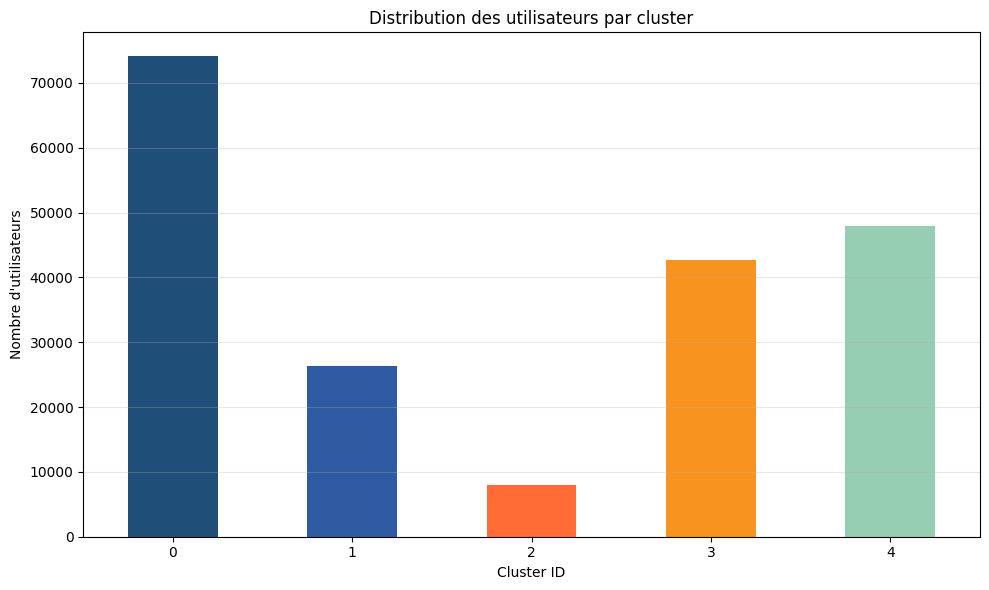

In [6]:
print("🎯 DISTRIBUTION DES CLUSTERS")
print("=" * 40)

cluster_distribution = df_users['cluster'].value_counts().sort_index()
cluster_percentages = (cluster_distribution / len(df_users) * 100).round(1)

for cluster_id in sorted(df_users['cluster'].unique()):
    count = cluster_distribution[cluster_id]
    pct = cluster_percentages[cluster_id]
    print(f"Cluster {cluster_id}: {count:,} utilisateurs ({pct}%)")

# Visualisation
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind='bar', color=['#1f4e79', '#2d5aa0', '#ff6b35', '#f7931e', '#96CEB4'])
plt.title('Distribution des utilisateurs par cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Nombre d\'utilisateurs')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
print("🎯 TOPICS POPULAIRES PAR CLUSTER")
print("=" * 40)

# Identifier les colonnes topics
topic_columns = [col for col in df_users.columns if col.startswith('topic_') and col != 'topic_count']
print(f"Topics détectés: {topic_columns}")

# Fonction pour analyser les topics d'un cluster
def analyze_cluster_topics(cluster_id, top_n=5):
    cluster_users = df_users[df_users['cluster'] == cluster_id]
    
    if cluster_users.empty:
        return {}
    
    topic_scores = {}
    for topic_col in topic_columns:
        # Topic ID depuis le nom de colonne
        topic_id = topic_col.replace('topic_', '')
        # Somme des interactions pour ce topic dans le cluster
        total_interactions = cluster_users[topic_col].sum()
        # Pourcentage d'utilisateurs du cluster qui ont interagi avec ce topic
        users_with_topic = (cluster_users[topic_col] > 0).sum()
        pct_users = (users_with_topic / len(cluster_users)) * 100
        
        topic_scores[topic_id] = {
            'total_interactions': int(total_interactions),
            'users_count': int(users_with_topic),
            'users_percentage': round(pct_users, 1),
            'avg_interactions_per_user': round(total_interactions / len(cluster_users), 2)
        }
    
    # Trier par nombre total d'interactions
    sorted_topics = dict(sorted(topic_scores.items(), 
                               key=lambda x: x[1]['total_interactions'], 
                               reverse=True))
    
    return dict(list(sorted_topics.items())[:top_n])

# Analyser chaque cluster
cluster_topics = {}
for cluster_id in sorted(df_users['cluster'].unique()):
    cluster_topics[cluster_id] = analyze_cluster_topics(cluster_id, top_n=6)
    
    print(f"\n🔸 CLUSTER {cluster_id}")
    print("-" * 20)
    
    for topic_id, stats in cluster_topics[cluster_id].items():
        if stats['total_interactions'] > 0:  # Ignorer les topics sans interactions
            print(f"Topic {topic_id}: {stats['total_interactions']} interactions "
                  f"({stats['users_percentage']}% des users, "
                  f"moy: {stats['avg_interactions_per_user']}/user)")

🎯 TOPICS POPULAIRES PAR CLUSTER
Topics détectés: ['topic_-1', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15']

🔸 CLUSTER 0
--------------------
Topic -1: 15556 interactions (18.4% des users, moy: 0.21/user)
Topic 0: 1995 interactions (2.5% des users, moy: 0.03/user)
Topic 1: 1990 interactions (2.4% des users, moy: 0.03/user)
Topic 14: 1043 interactions (1.3% des users, moy: 0.01/user)
Topic 15: 857 interactions (1.1% des users, moy: 0.01/user)
Topic 2: 818 interactions (1.1% des users, moy: 0.01/user)

🔸 CLUSTER 1
--------------------
Topic -1: 61756 interactions (92.1% des users, moy: 2.34/user)
Topic 0: 22301 interactions (52.9% des users, moy: 0.84/user)
Topic 1: 19091 interactions (48.4% des users, moy: 0.72/user)
Topic 2: 8075 interactions (23.7% des users, moy: 0.31/user)
Topic 15: 4782 interactions (16.3% des users, moy: 0.18/user)
Topic 5: 4683 i

In [8]:
print("📋 TYPES DE CONTENUS PRÉFÉRÉS PAR CLUSTER")
print("=" * 45)

# Analyser les colonnes de consommation de contenu
content_type_columns = [col for col in df_users.columns if col.startswith('nb_') and 'topic' not in col]
print(f"Colonnes de consommation détectées: {content_type_columns}")

def analyze_cluster_content_preferences(cluster_id):
    cluster_users = df_users[df_users['cluster'] == cluster_id]
    
    if cluster_users.empty:
        return {}
    
    preferences = {}
    for col in content_type_columns:
        if col in cluster_users.columns:
            total = cluster_users[col].sum()
            avg_per_user = cluster_users[col].mean()
            users_with_content = (cluster_users[col] > 0).sum()
            pct_users = (users_with_content / len(cluster_users)) * 100
            
            preferences[col] = {
                'total': int(total),
                'avg_per_user': round(avg_per_user, 2),
                'users_with_content': int(users_with_content),
                'percentage_users': round(pct_users, 1)
            }
    
    # Trier par moyenne par utilisateur
    sorted_prefs = dict(sorted(preferences.items(), 
                              key=lambda x: x[1]['avg_per_user'], 
                              reverse=True))
    
    return sorted_prefs

# Analyser les préférences par cluster
cluster_content_preferences = {}

for cluster_id in sorted(df_users['cluster'].unique()):
    cluster_content_preferences[cluster_id] = analyze_cluster_content_preferences(cluster_id)
    
    print(f"\n🔸 CLUSTER {cluster_id} - Préférences de contenu")
    print("-" * 35)
    
    for content_type, stats in list(cluster_content_preferences[cluster_id].items())[:5]:
        if stats['avg_per_user'] > 0:
            print(f"{content_type}: {stats['avg_per_user']} moy/user "
                  f"({stats['percentage_users']}% des users)")

📋 TYPES DE CONTENUS PRÉFÉRÉS PAR CLUSTER
Colonnes de consommation détectées: ['nb_fiche_outils', 'nb_guide_pratique', 'nb_transition_ecologique', 'nb_sante_mentale', 'nb_ecole_inclusive', 'nb_cps', 'nb_reussite_tous_eleves', 'nb_vote', 'nb_comments', 'nb_opened_mail', 'nb_clicked_mail']

🔸 CLUSTER 0 - Préférences de contenu
-----------------------------------
nb_opened_mail: 33.48 moy/user (81.1% des users)
nb_clicked_mail: 5.2 moy/user (46.0% des users)
nb_guide_pratique: 0.25 moy/user (17.2% des users)
nb_reussite_tous_eleves: 0.21 moy/user (15.9% des users)
nb_fiche_outils: 0.17 moy/user (8.5% des users)

🔸 CLUSTER 1 - Préférences de contenu
-----------------------------------
nb_opened_mail: 39.63 moy/user (90.4% des users)
nb_clicked_mail: 6.52 moy/user (54.7% des users)
nb_fiche_outils: 3.11 moy/user (84.7% des users)
nb_reussite_tous_eleves: 1.15 moy/user (52.3% des users)
nb_guide_pratique: 1.07 moy/user (41.0% des users)

🔸 CLUSTER 2 - Préférences de contenu
------------------

In [9]:
print("👥 PROFIL DÉMOGRAPHIQUE PAR CLUSTER")
print("=" * 40)

demographic_columns = ['anciennete', 'degre', 'maternelle', 'elementaire', 'college', 'lycee', 'lycee_pro']

def analyze_cluster_demographics(cluster_id):
    cluster_users = df_users[df_users['cluster'] == cluster_id]
    
    if cluster_users.empty:
        return {}
    
    demo = {}
    
    # Ancienneté moyenne
    if 'anciennete' in cluster_users.columns:
        demo['anciennete_moyenne'] = round(cluster_users['anciennete'].mean(), 1)
    
    # Répartition par degré
    if 'degre' in cluster_users.columns:
        degre_dist = cluster_users['degre'].value_counts(normalize=True) * 100
        demo['degre_distribution'] = {int(k): round(v, 1) for k, v in degre_dist.items()}
    
    # Niveaux d'enseignement
    niveaux = ['maternelle', 'elementaire', 'college', 'lycee', 'lycee_pro']
    demo['niveaux'] = {}
    
    for niveau in niveaux:
        if niveau in cluster_users.columns:
            pct = (cluster_users[niveau].sum() / len(cluster_users)) * 100
            demo['niveaux'][niveau] = round(pct, 1)
    
    return demo

# Analyser la démographie par cluster
cluster_demographics = {}

for cluster_id in sorted(df_users['cluster'].unique()):
    cluster_demographics[cluster_id] = analyze_cluster_demographics(cluster_id)
    
    print(f"\n🔸 CLUSTER {cluster_id}")
    print("-" * 20)
    
    demo = cluster_demographics[cluster_id]
    print(f"Ancienneté moyenne: {demo.get('anciennete_moyenne', 'N/A')} ans")
    
    print("Niveaux d'enseignement:")
    for niveau, pct in demo.get('niveaux', {}).items():
        if pct > 10:  # Afficher seulement si > 10%
            print(f"  - {niveau}: {pct}%")

👥 PROFIL DÉMOGRAPHIQUE PAR CLUSTER

🔸 CLUSTER 0
--------------------
Ancienneté moyenne: 13.7 ans
Niveaux d'enseignement:
  - maternelle: 41.2%
  - elementaire: 64.9%

🔸 CLUSTER 1
--------------------
Ancienneté moyenne: 15.0 ans
Niveaux d'enseignement:
  - maternelle: 29.4%
  - elementaire: 36.2%
  - college: 26.0%
  - lycee: 11.7%

🔸 CLUSTER 2
--------------------
Ancienneté moyenne: 15.8 ans
Niveaux d'enseignement:
  - maternelle: 26.0%
  - elementaire: 33.1%
  - college: 29.2%
  - lycee: 13.8%
  - lycee_pro: 12.3%

🔸 CLUSTER 3
--------------------
Ancienneté moyenne: 14.3 ans
Niveaux d'enseignement:
  - maternelle: 26.8%
  - elementaire: 40.2%
  - college: 22.0%
  - lycee: 11.3%

🔸 CLUSTER 4
--------------------
Ancienneté moyenne: 15.4 ans
Niveaux d'enseignement:
  - college: 57.6%
  - lycee: 26.0%
  - lycee_pro: 17.2%


In [ ]:
print("🎯 SYNTHÈSE POUR LE MAPPING")
print("=" * 30)

# Créer un résumé structuré pour chaque cluster
cluster_summary = {}

for cluster_id in sorted(df_users['cluster'].unique()):
    
    # Topics principaux (top 3)
    top_topics = list(cluster_topics[cluster_id].keys())[:3]
    
    # Types de contenu préférés (top 3)
    top_content_types = list(cluster_content_preferences[cluster_id].keys())[:3]
    
    # Niveau principal
    niveaux = cluster_demographics[cluster_id].get('niveaux', {})
    niveau_principal = max(niveaux.items(), key=lambda x: x[1]) if niveaux else ('mixte', 0)
    
    cluster_summary[cluster_id] = {
        'size': int(cluster_distribution[cluster_id]),
        'percentage': float(cluster_percentages[cluster_id]),
        'top_topics': top_topics,
        'preferred_content_types': top_content_types,
        'main_teaching_level': niveau_principal[0],
        'teaching_level_percentage': niveau_principal[1],
        'avg_experience': cluster_demographics[cluster_id].get('anciennete_moyenne', 0)
    }
    
    print(f"\n📊 CLUSTER {cluster_id} ({cluster_summary[cluster_id]['size']} users)")
    print(f"Topics principaux: {top_topics}")
    print(f"Types préférés: {[t.replace('nb_', '') for t in top_content_types[:2]]}")
    print(f"Niveau principal: {niveau_principal[0]} ({niveau_principal[1]}%)")